# **INTRODUCTION**


Recommendation engines have become an increasingly important tool in the world of online commerce. By analyzing a customer's purchase history, these systems are able to make personalized recommendations for products or services that the customer might be interested in. This not only helps to improve the customer experience, but it can also drive sales and increase customer loyalty. In this article, we will explore the basics of recommendation engines and how they can be used to improve the shopping experience for customers. We will also discuss some of the challenges and considerations involved in building and implementing a recommendation engine based on purchase history.

### Trendyol Recommendation Engine

Trendyol verisini kullanarak müşterilerin aldıkları ürünleri baz alarak müşterinin yeni alabilecek ürünleri önerim sistemi olacaktır. 



In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import requests as rq
import matplotlib as plt
import time
import random
from docutils.nodes import inline
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
#import turicreate as tc
import sys
import sqlalchemy

sys.path.append("..")

# For content based recommendation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import re

# import warnings

# warnings.filterwarnings('ignore')


# **Dataset:**

**Column's Names:**

 0   partition_date: Satın alma tarihi

 1   orderparentid     : Satın alım kodu

 2   user_id           : Satın alan kullanıcı

 3   productcontentid  : Satın alınan ürün kodu

 4   brand_id          : Ürünün marka kodu

 5   category_id       : Ürünün dahil olduğu kategori kodu

 6   category_name     : Ürünün dahil olduğu kategorinin adı

 7   gender            : Ürünün cinsiyeti

 8   price             : Ürünün fiyatı

 9   color_id          : Ürünün renk kodu

 10  business_unit     : Ürünün dahil olduğu genel grubun adı

 11  ImageLink         : Ürün görselinin linki



### **1. Uploading Dataset**

In [ ]:
data = pd.read_csv('https://storage.googleapis.com/ty2020/reco.csv.gz')

In [ ]:
data['partition_date'] = pd.to_datetime(data['partition_date']).dt.normalize()

In [ ]:
data.head()

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink
0,2020-08-20,335057357,86386,39328996,919155,418,Sandalet,Kadın,319.98,14.0,Branded Shoes B,https://cdn.dsmcdn.com//ty1/product/media/imag...
1,2020-08-24,337401625,59469,31903343,121,1827,Banyo Dolabı,Unisex,1195.56,3.0,Bahçe & Yapı Market & Hırdavat,https://cdn.dsmcdn.com//assets/product/media/i...
2,2020-08-26,338457012,51248,34726400,40,604,T-Shirt,Kadın,37.99,14.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/i...
3,2020-08-22,336681542,29380,32920640,7651,604,T-Shirt,Kadın,24.99,6.0,Kadın A,https://cdn.dsmcdn.com//assets/product/media/i...
4,2020-08-20,335736916,68368,39035716,3395,599,Kazak,Kadın,79.90,16.0,Kadın A,https://cdn.dsmcdn.com//ty1/product/media/imag...


In [ ]:
print(data.shape)

(508228, 12)


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508228 entries, 0 to 508227
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   partition_date    508228 non-null  datetime64[ns]
 1   orderparentid     508228 non-null  int64         
 2   user_id           508228 non-null  int64         
 3   productcontentid  508228 non-null  int64         
 4   brand_id          508228 non-null  int64         
 5   category_id       508228 non-null  int64         
 6   category_name     508228 non-null  object        
 7   gender            475493 non-null  object        
 8   price             508228 non-null  float64       
 9   color_id          375670 non-null  float64       
 10  business_unit     508228 non-null  object        
 11  ImageLink         508228 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 46.5+ MB
None


Let's see how many unique values are in the data set

In [ ]:
# number of unique users
num_of_users = len(data["user_id"].unique())
print("Number of Users:", num_of_users)

# number of unique productcontentid
num_of_products = len(data["productcontentid"].unique())
print("Number of prodcutcontentid", num_of_products)

# number of unique brand_id
num_of_brands = len(data["brand_id"].unique())
print("Number of brands:", num_of_brands)

# number of unique category_id
num_of_categories = len(data["category_id"].unique())
print("Number of categories:", num_of_categories)

# number of unique category_name
num_of_category_names = len(data["category_name"].unique())
print("Number of category_names:", num_of_category_names)

# number of unique orderparentid
num_of_orderparentid = len(data["orderparentid"].unique())
print("Number of Orderparentid:", num_of_orderparentid)

# number of unique gender
num_of_genders = data["gender"].unique()
print("Number of Gender:", num_of_genders)

Number of Users: 108944
Number of prodcutcontentid 184092
Number of brands: 16838
Number of categories: 1879
Number of category_names: 1879
Number of Orderparentid: 249864
Number of Gender: ['Kadın' 'Unisex' nan 'Erkek']


# **Wordcloud for category_name:**
Let's examine the popularity of purchased categories with WordCloud.

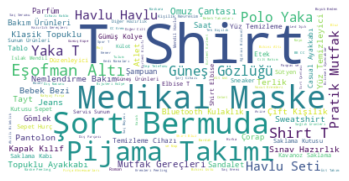

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

stopwords = set(STOPWORDS)

#Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(data['category_name'].to_string())
word_cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(data['category_name'].to_string())

#Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Data prepration for recommendation algorithms, First, we organize our data by setting the purchase per person at least 4 to achieve a better result.


In [ ]:
merged = pd.DataFrame(data.groupby("user_id")["orderparentid"].count()).reset_index()
cleared_data = data.drop(columns=["partition_date", "price"])
data_cleaned = merged.merge(cleared_data, on="user_id")
final_data = data_cleaned[data_cleaned["orderparentid_x"] > 4]

print(final_data.head().to_string())
print(final_data.shape)
print(final_data.info())

    user_id  orderparentid_x  orderparentid_y  productcontentid  brand_id  category_id category_name gender  color_id business_unit                                                                                          ImageLink
7       104                5        338745787          44752126      7651          604       T-Shirt  Erkek      17.0       Kadın A      https://cdn.dsmcdn.com//ty7/product/media/images/20200806/8/7251712/79274604/3/3_org_zoom.jpg
8       104                5        338745787          36511807      7651          604       T-Shirt  Erkek      17.0       Kadın A  https://cdn.dsmcdn.com//assets/product/media/images/20200306/11/4082924/64991410/1/1_org_zoom.jpg
9       104                5        338745787          44751760      7651          604       T-Shirt  Erkek       2.0       Kadın A     https://cdn.dsmcdn.com//ty9/product/media/images/20200901/11/9239398/82986407/1/1_org_zoom.jpg
10      104                5        338745787          44750797      7651   

In [ ]:
final_data["orderparentid_x"].sort_values(ascending = False)

339294    6425
343314    6425
343320    6425
343319    6425
343318    6425
          ... 
233923       5
233921       5
233920       5
233919       5
7            5
Name: orderparentid_x, Length: 358913, dtype: int64

In [ ]:
final_data1 = final_data.iloc[:30000]

To create a product recommendation system using a collaborative filtering algorithm, the data needs to be structured so that each record includes information on which items each customer has purchased. Currently, the data consists of individual items purchased by customers. To address this, we will transform the data into a user-to-item matrix, where each row represents a customer and the columns correspond to different products. This format will allow us to use the collaborative filtering algorithm to build the recommendation system.

In [ ]:
customer_item_matrix = final_data1.pivot_table(
    index='user_id',
    columns='productcontentid',
    values='category_id',
    aggfunc='sum'
)

print(customer_item_matrix.head())

productcontentid  52015     52046     52071     52098     52099     52204     \
user_id                                                                        
104                    NaN       NaN       NaN       NaN       NaN       NaN   
105                    NaN       NaN       NaN       NaN       NaN       NaN   
167                    NaN       NaN       NaN       NaN       NaN       NaN   
174                    NaN       NaN       NaN       NaN       NaN       NaN   
190                    NaN       NaN       NaN       NaN       NaN       NaN   

productcontentid  52304     52307     52385     52386     ...  46837954  \
user_id                                                   ...             
104                    NaN       NaN       NaN       NaN  ...       NaN   
105                    NaN       NaN       NaN       NaN  ...       NaN   
167                    NaN       NaN       NaN       NaN  ...       NaN   
174                    NaN       NaN       NaN       NaN  ...   

To use this data to build a product recommendation system, we need to convert it into a matrix where each value represents whether or not a particular product was purchased by a particular customer. We can do this by coding the data as 0s and 1s, where a value of 1 indicates that the product was bought by the customer, and a value of 0 indicates that the product was not bought by the customer.

For example, the matrix we have now shows the total quantities purchased for each product for each customer. We can transform this into a 0-1 matrix by replacing the quantities with 1s if the product was purchased by the customer, and 0s if the product was not purchased.

This will allow us to use the 0-1 matrix as input for a collaborative filtering algorithm to build a product recommendation system.

In [ ]:
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)

To transform the data into a 0-1 matrix, we can use the applymap() function from the pandas library. This function applies a given function to each element of a DataFrame.

In this case, we are using a lambda function that codes all elements whose values are greater than 0 with 1, and the rest with 0.

In [ ]:
customer_item_matrix

productcontentid,52015,52046,52071,52098,52099,52204,52304,52307,52385,52386,...,46837954,46846439,46853373,46855144,46859761,46899769,46928384,46938926,46958108,47048393
user_id,,,,,,,,,,,,,,,,,,,,,
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
20050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have a 0-1 matrix that we can use as input for a collaborative filtering algorithm to build a product recommendation system.

# **Collaborative filtering**

There are two approaches to building a product recommendation system: the user-based approach and the item-based approach.

In the user-based approach, the similarities between users are calculated based on their item purchase history. This means that users who have purchased similar items are considered more similar to each other.

In the item-based approach, on the other hand, the similarities between items are calculated based on which items are often purchased together. This means that items that are frequently purchased together are considered more similar to each other.

Both of these approaches can be used to build a product recommendation system, and which one is more appropriate will depend on the specific needs of the application.

To measure the similarity between users or between articles, we will use the cosine_similarity method in the scikit-learn package.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# **User-based collaboration filters and recommendations**

To build a user-based collaborative filtering algorithm, it is necessary to calculate the cosine similarities between users. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. In the context of a recommendation system, the vectors represent the item purchase histories of different users, and the cosine similarity measures the similarity between two users based on the items they have purchased.

To calculate the cosine similarities between users, we can use the cosine_similarity() function from the sklearn.metrics.pairwise module. This function takes as input a matrix of user vectors and returns a matrix of cosine similarities between the users.

In [ ]:
user_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix)
)

In [ ]:
user_user_sim_matrix 

,0,1,2,3,4,5,6,7,8,9,...,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In this code, we are using the cosine_similarity() function from the sklearn.metrics.pairwise module to calculate the cosine similarities between the samples. This function returns the similarities as an array.

Then, we create a DataFrame from this output array and store it in a variable called user_user_sim_matrix, which represents the user-user similarity array. The index and column names of the DataFrame may not be easily interpretable, as each column and row represents an individual customer.

To make the DataFrame more understandable, we can consider renaming the index and column names to represent the customer ID's which is user_id. This will make it easier to understand which customers are being compared in the DataFrame.

In [ ]:
user_user_sim_matrix.columns = customer_item_matrix.index

In [ ]:
user_user_sim_matrix

user_id,104,105,167,174,190,197,216,222,232,234,...,20035,20037,20038,20039,20042,20044,20048,20050,20051,20052
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


The user similarity matrix shows the cosine similarities between pairs of users. As expected, the cosine similarity between a user and itself is 1, which is reflected in the diagonal elements of the matrix.

The other elements in the matrix represent the cosine similarity between two different users. For example, if the measure of cosine similarity between users 1031 and 822 is 0.2857, it means that these two users have purchased similar items and can be considered similar to each other.

By examining the user similarity matrix, it is possible to see which users are similar to each other and which users have purchased similar items. This information can be used to build a user-based collaborative filtering algorithm for making product recommendations.

In [ ]:
user_user_sim_matrix['user_id'] = customer_item_matrix.index
user_user_sim_matrix = user_user_sim_matrix.set_index('user_id')

In [ ]:
rand_user1 = random.choice(list(user_user_sim_matrix.columns))
print("user_id:", rand_user1)

user_id: 18819


In [ ]:
user_user_sim_matrix.loc[rand_user1].sort_values(ascending=False).head(10)


user_id
18819    1.000000
1479     0.220564
14474    0.201347
16335    0.134231
5879     0.134231
12845    0.134231
19360    0.134231
19309    0.124274
15841    0.124274
9297     0.124274
Name: 18819, dtype: float64

In [ ]:
items_bought_by_A = set(customer_item_matrix.loc[rand_user1].iloc[
    customer_item_matrix.loc[rand_user1].to_numpy().nonzero()
].index)

To build a recommendation system using a user-based collaborative filtering algorithm, we can follow the strategy outlined in your description.

\

1. Identify the items that users 1031 and 822 have already purchased. This can be done by looking at the item purchase history data for these users.
2. Find the items that user 822 has not purchased, but user 1031 has. These are the items that we will recommend to user 822.
3. Assume that user 822 has a high probability of buying these items because they have purchased similar items in the past, according to the user similarity matrix.
4. Recommend the list of items to user 822. 

\

By following these steps, we can use the user similarity matrix and the item purchase history data to make personalized recommendations to user 822 based on the items that similar users (in this case, user 1031) have purchased.


In [ ]:
items_bought_by_A

{4239824,
 4434225,
 4460371,
 31585782,
 34072104,
 34481779,
 34553142,
 34955686,
 35649883,
 35724110,
 36523790,
 36523791,
 36523795,
 36523796,
 36554513,
 36921403,
 37110869,
 38551215,
 39191881,
 39328522,
 39383421,
 40759434,
 40945766,
 40976209,
 41316650,
 42565353,
 42565754,
 42566953,
 42660099,
 42660158,
 42670749,
 42677438,
 42694803,
 44137866,
 44140720,
 44605945,
 46320088}

In [ ]:
final_data1.loc[
    final_data1['productcontentid'].isin(items_bought_by_A), 
    ['productcontentid', 'category_name','gender','ImageLink']
].drop_duplicates().set_index('productcontentid')

,category_name,gender,ImageLink
productcontentid,,,
42565754,Vücut Kremleri & Peeling,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...
42565353,BB & CC Krem,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...
42670749,Tayt,Kadın,https://cdn.dsmcdn.com//ty5/product/media/imag...
42694803,Bluz,Kadın,https://cdn.dsmcdn.com//ty5/product/media/imag...
42660099,Nemlendirme & Bakım,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...
36523790,Hırka,Kadın,https://cdn.dsmcdn.com//assets/product/media/i...
31585782,Eşofman Altı,Kadın,https://cdn.dsmcdn.com//ty10/product/media/ima...
39328522,Hırka,Kadın,https://cdn.dsmcdn.com//ty2/product/media/imag...
36523796,Hırka,Kadın,https://cdn.dsmcdn.com//assets/product/media/i...


In [ ]:
items_bought_by_B = set(customer_item_matrix.loc[1479.0].iloc[
    customer_item_matrix.loc[1479].to_numpy().nonzero()
].index)

In [ ]:
final_data1.loc[
    final_data1['productcontentid'].isin(items_bought_by_B), 
    ['productcontentid', 'category_name','gender','ImageLink']
].drop_duplicates().set_index('productcontentid')

,category_name,gender,ImageLink
productcontentid,,,
42565754,Vücut Kremleri & Peeling,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...
42565353,BB & CC Krem,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...
43372909,Vücut Kremleri & Peeling,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...
42660099,Nemlendirme & Bakım,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...
42660139,Yüz Temizleyici,Unisex,https://cdn.dsmcdn.com//ty5/product/media/imag...


In [ ]:
items_bought_by_B

{42565353, 42565754, 42660099, 42660139, 43372909}

In [ ]:
items_to_recommend_to_B = items_bought_by_A - items_bought_by_B
items_to_recommend_to_B

{4239824,
 4434225,
 4460371,
 31585782,
 34072104,
 34481779,
 34553142,
 34955686,
 35649883,
 35724110,
 36523790,
 36523791,
 36523795,
 36523796,
 36554513,
 36921403,
 37110869,
 38551215,
 39191881,
 39328522,
 39383421,
 40759434,
 40945766,
 40976209,
 41316650,
 42566953,
 42660158,
 42670749,
 42677438,
 42694803,
 44137866,
 44140720,
 44605945,
 46320088}

In [ ]:
final_data1.loc[
    final_data1['productcontentid'].isin(items_to_recommend_to_B), 
    ['productcontentid', 'category_name','gender','ImageLink']
].drop_duplicates().set_index('productcontentid')

,category_name,gender,ImageLink
productcontentid,,,
42670749,Tayt,Kadın,https://cdn.dsmcdn.com//ty5/product/media/imag...
42694803,Bluz,Kadın,https://cdn.dsmcdn.com//ty5/product/media/imag...
36523790,Hırka,Kadın,https://cdn.dsmcdn.com//assets/product/media/i...
31585782,Eşofman Altı,Kadın,https://cdn.dsmcdn.com//ty10/product/media/ima...
39328522,Hırka,Kadın,https://cdn.dsmcdn.com//ty2/product/media/imag...
36523796,Hırka,Kadın,https://cdn.dsmcdn.com//assets/product/media/i...
36523791,Hırka,Kadın,https://cdn.dsmcdn.com//assets/product/media/i...
35724110,Şort & Bermuda,Kadın,https://cdn.dsmcdn.com//assets/product/media/i...
4434225,Fondöten,Kadın,https://cdn.dsmcdn.com//Assets/ProductImages/o...


User-based collaborative filtering is a technique that can be used to make personalized product recommendations to individual customers based on their purchase history and the purchase histories of similar users. By recommending products that are likely to be of interest to each target customer, you can increase conversions and improve the effectiveness of your marketing efforts.


However, user-based collaborative filtering has one major disadvantage: it relies on the individual customer's purchase history, which means that it is not suitable for making recommendations to new customers who have no purchase history. In this case, there is not enough data to compare the new customer to other users, and the recommendation system will not be able to make accurate recommendations.

To handle this problem, we can use item-based collaborative filtering instead. In item-based collaborative filtering, the similarities between items are calculated based on which items are often purchased together. This means that items that are frequently purchased together are considered more similar to each other.

We can use item-based collaborative filtering to make recommendations to new customers, as well as to existing customers, by considering the items that they have purchased and recommending similar items. We will discuss item-based collaborative filtering in more detail in the next section.






# **Collaborative filtering based on items and recommendations**

Item-based collaborative filtering is a technique for making product recommendations that is similar to user-based collaborative filtering, except that it uses measures of similarity between items rather than between users.

To implement item-based collaborative filtering, we need to calculate the cosine similarities between pairs of items. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. In the context of a recommendation system, the vectors represent the item purchase histories of different users, and the cosine similarity measures the similarity between two items based on how often they are purchased together by different users.

Once we have the cosine similarities between the items, we can use them to build an item-based collaborative filtering algorithm for making product recommendations.

In [ ]:
item_item_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix.T)
)

The process of calculating the cosine similarities between items using item-based collaborative filtering is similar to calculating the cosine similarities between users using user-based collaborative filtering. The main difference is that we need to transpose the customer-item matrix so that the rows represent individual items and the columns represent the customers.

To use the cosine_similarity function from the metrics.pairwise module in the sklearn package. To correctly name the indexes and columns with the product codes

In [ ]:
item_item_sim_matrix

,0,1,2,3,4,5,6,7,8,9,...,21548,21549,21550,21551,21552,21553,21554,21555,21556,21557
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
item_item_sim_matrix.columns = customer_item_matrix.T.index

item_item_sim_matrix['productcontentid'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('productcontentid')

In [ ]:
rand_user = random.choice(list(final_data1.productcontentid))
rand_user

In [ ]:
aauser_data = data.loc[data["productcontentid"] == rand_user]
aauser_data

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink
157340,2020-08-08,328720004,10554,36803116,4649,867,Epilatör,Kadın,179.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
181992,2020-08-08,328651693,95889,36803116,4649,867,Epilatör,Kadın,178.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
182053,2020-07-08,328222025,95889,36803116,4649,867,Epilatör,Kadın,179.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
183462,2020-08-16,331790767,73917,36803116,4649,867,Epilatör,Kadın,230.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
319466,2020-08-08,328583251,17773,36803116,4649,867,Epilatör,Kadın,179.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
345513,2020-08-23,337123165,85115,36803116,4649,867,Epilatör,Kadın,238.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
347197,2020-07-31,325470900,52933,36803116,4649,867,Epilatör,Kadın,197.5,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
362836,2020-07-29,324937124,86414,36803116,4649,867,Epilatör,Kadın,193.9,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
370550,2020-10-08,329520880,38215,36803116,4649,867,Epilatör,Kadın,178.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...
439625,2020-08-25,337701566,41934,36803116,4649,867,Epilatör,Kadın,238.0,14.0,Kişisel Bakım Aletleri,https://cdn.dsmcdn.com//assets/product/media/i...


In [ ]:
top_5_similar_items = list(
   item_item_sim_matrix.loc[rand_user].sort_values(ascending=False).iloc[:6].index
)

As before, diagonal elements have values of 1. This is because the similarity between an element and itself is 1, which means that the two are identical. The rest of the elements contain the values for measuring the similarity between the elements based on the calculation of cosine similarity.

For example, if you look at the similarity matrix between elements above, the cosine similarity between the element with StockCode 52098 and the element with StockCode 39646446 is 0.707107. 

On the other hand, the cosine similarity between item 52098 and item 321912 is 0.288675 This suggests that the item with StockCode 4443412 is more similar to the item with StockCode 52098 than the item with StockCode 10125 to the item with StockCode 52098.

The strategy for making the product recommendation using this item similarity matrix is similar to the one we did using the user-based approach.

First, for the product given that the target customer bought, we are going to find the most similar items from the item-to-item similarity matrix that we just built.
Then, we're going to recommend these similar items to the customer because those similar items were bought by other customers who have purchased the product that the target customer initially bought.

In [ ]:
item_item_sim_matrix[rand_user].sort_values(ascending=False)

productcontentid
35135064    1.0
40229764    1.0
4137176     1.0
32662332    1.0
36803116    1.0
           ... 
32442196    0.0
32441283    0.0
32438873    0.0
32436377    0.0
47048393    0.0
Name: 36803116, Length: 21558, dtype: float64

To make product recommendations using an item-based collaborative filtering algorithm, we can follow a strategy similar to the one used in user-based collaborative filtering.

\

The steps involved in this process are as follows:

1. Identify the item that the target customer has purchased.
2. Find the most similar items to this item using the item similarity matrix. These are the items that we will recommend to the customer.
4. Recommend the similar items to the customer because they have been purchased by other customers who have also purchased the target item.
 
 
 For example, suppose we have a new customer who has just purchased a product with productcontentid xxx, and we want to include in our marketing emails some products that this customer is likely to buy. To find the items most similar to the item with productcontentid.

In [ ]:
final_data.loc[
    final_data['productcontentid'].isin(top_5_similar_items), 
    ['productcontentid', 'category_name', 'ImageLink']
].drop_duplicates().set_index('productcontentid').loc[top_5_similar_items]

,category_name,ImageLink
productcontentid,,
35135064,Buharlı Ütü,https://cdn.dsmcdn.com//assets/product/media/i...
40229764,Çatal & Bıçak & Kaşık Seti,https://cdn.dsmcdn.com//ty3/product/media/imag...
4137176,Cımbız,https://cdn.dsmcdn.com//ty10/product/media/ima...
32662332,Torbasız Süpürge,https://cdn.dsmcdn.com//assets/product/media/i...
36803116,Epilatör,https://cdn.dsmcdn.com//assets/product/media/i...
36466137,Ruj,https://cdn.dsmcdn.com//ty12/product/media/ima...


Using an item-based collaborative filtering algorithm, you can make personalized product recommendations for individual customers based on their purchase history and the purchase histories of other customers.

For example, suppose you have a customer who has just purchased a "El Yayı", and you want to include in your marketing emails some additional product recommendations for this customer. By analyzing the purchase histories of other customers who have also purchased "El Yayı", you can identify other items that are frequently purchased along with ceramic "El Yayı". These items can then be included in your marketing messages as additional product recommendations for the target customer. 

In this way, you can use an item-based collaborative filtering algorithm to make personalized product recommendations that are likely to be of interest to your customers, which can result in higher customer conversion rates.

# For New Customer

For the new customer I think that if we don't have any personal information about customer, what we can do? It can possible to create a algorithm that based on the new customers visiting date. Recommendation engine algorithm will work for the date's most sold products of the week but unique categories. When the customer click which category that want. After clicking the product, it will generate a most 10 products of this category.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend(productcontentid, user_id, user_item_matrix, top_k=5):
    # Find all users who have bought the product with productcontentid
    product_buyers = np.where(user_item_matrix[:, productcontentid] == 1)[0]
    
    # Calculate the similarity between user_id and each of the product buyers
    similarities = cosine_similarity(user_item_matrix[user_id, :].reshape(1, -1), 
                                      user_item_matrix[product_buyers, :])
    
    # Sort the users based on their similarity to user_id
    sorted_index = np.argsort(similarities, axis=1).flatten()[::-1]
    
    # Select the top K users
    top_k_index = sorted_index[:top_k]
    top_k_buyers = product_buyers[top_k_index]
    
    # Calculate the average of the binary indicator of whether each of the top K users bought the product
    likelihood = np.mean(user_item_matrix[top_k_buyers, productcontentid])
    
    return likelihood


In [ ]:
def first_time_user_recommendations1(data, date = None, top_k=10):
    # Filter the data to only include purchases from the specified date
    date_data = data[data['partition_date'] == date]
    
    # Group the data by product content ID and calculate the total number of purchases for each product
    product_counts = date_data.groupby('productcontentid')['user_id'].count().reset_index()
    
    # Sort the products by the number of purchases and select the top K products
    top_k_products = product_counts.sort_values('user_id', ascending=False).head(top_k)
    
    # Merge the top K products with the original data to get the image links for each product
    recommendations = top_k_products.merge(data, on='productcontentid')
    
    # Remove duplicate products and keep only the first unique product
    unique_products = recommendations.drop_duplicates(subset='productcontentid', keep='first')
    
    # Return the top K unique products and their image links as the recommendations for the first-time user
    return unique_products[['productcontentid', 'ImageLink']]


In [ ]:
first_time_user_recommendations1(data, date = "24.08.2020")

,productcontentid,ImageLink
0,39832331,https://cdn.dsmcdn.com//ty4/product/media/imag...
2864,43524099,https://cdn.dsmcdn.com//ty5/product/media/imag...
3611,44343292,https://cdn.dsmcdn.com//ty11/product/media/ima...
4034,43872989,https://cdn.dsmcdn.com//ty8/product/media/imag...
4188,40176537,https://cdn.dsmcdn.com//ty3/product/media/imag...
4495,41884185,https://cdn.dsmcdn.com//ty5/product/media/imag...
4798,39812560,https://cdn.dsmcdn.com//ty3/product/media/imag...
5190,44427949,https://cdn.dsmcdn.com//ty10/product/media/ima...
5336,6727656,https://cdn.dsmcdn.com//ty5/product/media/imag...
5706,44245850,https://cdn.dsmcdn.com//ty12/product/media/ima...


In [ ]:
from datetime import datetime
import pandas as pd

def first_time_user_recommendations_week(data, date, top_k=10):
    # Convert the date string to a datetime object
    date = datetime.strptime(date, '%d.%m.%Y')
    
    # Get the previous week's date range
    start_date = date - pd.Timedelta(days=7)
    end_date = date - pd.Timedelta(days=1)
    
    # Convert the "partition_date" column to a datetime type
    data['partition_date'] = pd.to_datetime(data['partition_date'])
    
    # Filter the data to only include purchases from the previous week
    week_data = data[(data['partition_date'] >= start_date) & (data['partition_date'] <= end_date)]
    
    # Group the data by product content ID and calculate the total number of purchases for each product
    product_counts = week_data.groupby('productcontentid')['user_id'].count().reset_index()
    
    # Sort the products by the number of purchases and select the top K products
    top_k_products = product_counts.sort_values('user_id', ascending=False).head(top_k)
    
    # Merge the top K products with the original data to get the image links for each product
    recommendations = top_k_products.merge(data, on='productcontentid')
    
    # Remove duplicate products and keep only the first unique product
    unique_products = recommendations.drop_duplicates(subset='productcontentid', keep='first')
    
    # Return the top K unique products and their image links as the recommendations for the first-time user
    return unique_products[['productcontentid', 'ImageLink']]


In [ ]:
first_time_user_recommendations_week(data, date = "29.08.2020")

,productcontentid,ImageLink
0,39832331,https://cdn.dsmcdn.com//ty4/product/media/imag...
2864,43524099,https://cdn.dsmcdn.com//ty5/product/media/imag...
3611,42565353,https://cdn.dsmcdn.com//ty5/product/media/imag...
4393,44343292,https://cdn.dsmcdn.com//ty11/product/media/ima...
4816,40176537,https://cdn.dsmcdn.com//ty3/product/media/imag...
5123,43872989,https://cdn.dsmcdn.com//ty8/product/media/imag...
5277,44822173,https://cdn.dsmcdn.com//ty11/product/media/ima...
5445,41884185,https://cdn.dsmcdn.com//ty5/product/media/imag...
5748,42032335,https://cdn.dsmcdn.com//ty5/product/media/imag...
6097,37338720,https://cdn.dsmcdn.com//assets/dev/product/med...


In [ ]:
def recommend_top_k_products_week(data, date, top_k=10):
    # Convert the date string to a datetime object
    date = datetime.strptime(date, '%d.%m.%Y')
    
    # Get the previous week's date range
    start_date = date - pd.Timedelta(days=7)
    end_date = date - pd.Timedelta(days=1)
    
    # Filter the data to only include purchases from the previous week
    week_data = data[(data['partition_date'] >= start_date) & (data['partition_date'] <= end_date)]
    
    # Group by the productcontentid and count the number of purchases
    product_counts = filtered_data.groupby(["productcontentid"])["productcontentid"].count().reset_index(name="counts")
    
    # Sort the results in descending order
    sorted_product_counts = product_counts.sort_values(by="counts", ascending=False)
    
    # Select the top k products
    top_k_products = sorted_product_counts.head(top_k)
    
    # Add the image link for each product
    result = pd.merge(top_k_products, data[["productcontentid", "ImageLink"]].drop_duplicates(), on="productcontentid", how="left")
    
    return result


In [ ]:
def recommend_top_k_products(data, productcontentid, top_k=10, date = None):
    # Filter the data based on the selected product category
    product_category = data.loc[productcontentid, "category_id"]
    filtered_data = data[data["category_id"] == product_category]
    
    # Get the previous week's date range
    start_date = date - np.timedelta64(7, 'D')
    end_date = date - np.timedelta64(1, 'D')
    
    # Filter the data based on the date range
    filtered_data = filtered_data[(filtered_data["partition_date"] >= start_date) & (filtered_data["partition_date"] <= end_date)]
    
    # Get the top k products based on their frequency of purchase
    top_k_products = filtered_data["productcontentid"].value_counts().head(top_k).index
    
    # Add the image link to the output
    recommended_products = data.loc[top_k_products, ["productcontentid", "ImageLink"]].drop_duplicates()
    
    return recommended_products


In [ ]:
recommend_top_k_products(data, productcontentid = 39328996, date="20.08.2020")

KeyError: ignored

In [ ]:
data.head()

In [ ]:
def recommend_top_k_products(data, clicked_product_id, top_k=10):
    # Get the category of the clicked product
    clicked_product_category = data[data["productcontentid"] == clicked_product_id]["category_id"].iloc[0]
    # Get all the products in the same category
    products_in_same_category = data[data["category_id"] == clicked_product_category]
    # Get the counts of the purchases of each product in the same category
    product_purchase_counts = products_in_same_category["productcontentid"].value_counts().reset_index()
    # Rename the columns
    product_purchase_counts.columns = ["productcontentid", "purchase_count"]
    # Get the top k products based on the purchase counts
    top_k_products = product_purchase_counts.sort_values(by="purchase_count", ascending=False).head(top_k).productcontentid.tolist()
    # Get the image link for each top k product
    top_k_products_data = data[data["productcontentid"].isin(top_k_products)]
    # Drop duplicates if any
    top_k_products_data = top_k_products_data.drop_duplicates(subset="productcontentid", keep="first")
    return top_k_products_data[["productcontentid", "ImageLink"]].reset_index(drop=True)


In [ ]:
recommend_top_k_products(data, clicked_product_id = 39328996)